In [2]:
import os
import librosa
import ffmpeg
from pydub import AudioSegment
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

import scipy.io.wavfile
import sys
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.layers import LSTM
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix

C:\Users\mjw27\Anaconda3\envs\voices\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## convert m4a to wav

In [11]:
print(os.getcwd())
db = './data_db/'

cnt = 0
for path, dirs, files in os.walk(db):
    for file in files:
        if file.endswith('m4a'):
            name, _ = file.split('.')
            file_path = os.path.join(path, file)
            wav_file = os.path.join(path, name+'.wav')
            try:
                track = AudioSegment.from_file(file_path, format="m4a")
                conv_wav = track.export(wav_file, format="wav")
                print(f'CONVERTING: {wav_file}')
                cnt += 1
                os.remove(file_path)
            except:
                print("Error")
print(cnt)

c:\Users\mjw27\Desktop\Speech-Emotion-Analyzer-master\gender_model
0


## 음성 feature

음성이 3초 이상인 data는 0.5초부터 2.5초씩 load(22050 * 2.5 = 55125)  
3초 이하인 data는 처음부터 load  
0.2초씩 slide window(4410)  

22050 300032
[ 2.6458016e-09 -2.3710547e-07  5.2862521e-07 ... -8.2520518e-07
  1.5283086e-06 -4.8197048e-06]
44100 600064


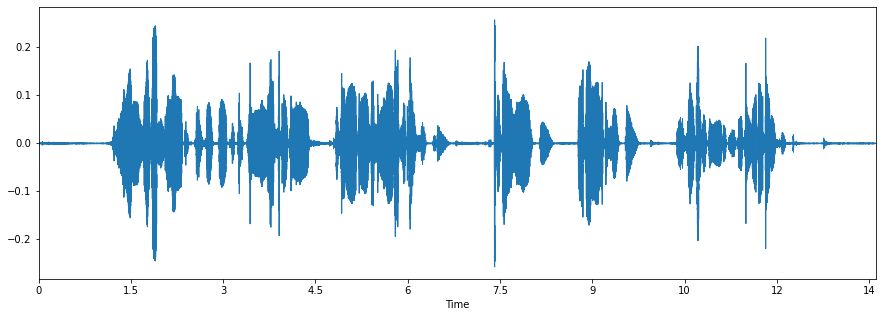

In [3]:
# 정규화, resampling
x, sr = librosa.load('./data_db/woman/kor/이지윤_angry_12.wav')
print(sr, len(x))
print(x)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sr)
# 정규화 x
sr,x = scipy.io.wavfile.read('./data_db/woman/kor/이지윤_angry_12.wav')
print(sr, len(x))


In [ ]:
db = './data_db/'
language = ['eng', 'kor']
gender = ['man', 'woman']

sr = 22050
win_size = int(sr *  2.5)
win_slide = int(sr * 0.2)
margin = win_size // win_slide

min_audio = int(sr * 3)
offset = int(sr * 0.5)

df = pd.DataFrame(columns=['gender', 'language', 'feature'])
cnt = 0

for path, dirs, files in os.walk(db):
    for file in files:
        lang = path.split('\\')[-1]
        gen = path.split('\\')[0].split('/')[-1]

        file_path = os.path.join(path, file)
        data, sr = librosa.load(file_path)

        if len(data) >= min_audio:
            data = data[offset:]
        step = round(len(data) / win_slide - margin)

        if step <= 0:
            pass
        else:
            for i in range(step):
                s_idx = i * win_slide
                e_idx = i * win_slide + win_size
                if e_idx >= len(data):
                    break
                step_data = data[s_idx:e_idx]
                mfccs = np.mean(librosa.feature.mfcc(y=step_data, sr=sr, n_mfcc=20), axis=0) #(108,)
                df.loc[cnt, 'gender'] = gender.index(gen)
                df.loc[cnt, 'language'] = language.index(lang)
                df.loc[cnt, 'feature'] = mfccs.tolist()
                cnt += 1

print(df)


      gender language                                            feature
0          0        0  [-43.00763702392578, -43.00763702392578, -43.0...
1          0        0  [-43.005123138427734, -41.46041488647461, -38....
2          0        0  [-39.88351058959961, -39.199073791503906, -38....
3          0        0  [-43.11376190185547, -41.95098114013672, -38.7...
4          0        0  [-42.62168884277344, -42.62168884277344, -42.6...
...      ...      ...                                                ...
42063      1        1  [-3.2725765705108643, -2.7503724098205566, -3....
42064      1        1  [-7.998719215393066, -8.855375289916992, -10.7...
42065      1        1  [-11.408967971801758, -12.65507698059082, -13....
42066      1        1  [-11.39708423614502, -12.339877128601074, -13....
42067      1        1  [-20.837121963500977, -22.15406036376953, -13....

[42068 rows x 3 columns]


In [ ]:
df.to_csv('./data_feature.csv', index=None)


## data load


In [35]:
dataset = pd.read_csv('./data_feature_mfcc30.csv', converters={'feature':pd.eval})
print(dataset[:10])

   gender  language                                            feature
0       0         0  [-28.6717586517334, -28.6717586517334, -28.671...
1       0         0  [-28.670082092285156, -27.436939239501953, -25...
2       0         0  [-26.45915985107422, -25.73929786682129, -25.5...
3       0         0  [-28.742509841918945, -27.76581382751465, -25....
4       0         0  [-28.414459228515625, -28.414459228515625, -28...
5       0         0  [-27.798532485961914, -27.611238479614258, -26...
6       0         0  [-28.304637908935547, -28.304637908935547, -28...
7       0         0  [-30.106170654296875, -30.106170654296875, -30...
8       0         0  [-30.19639015197754, -29.058759689331055, -28....
9       0         0  [-29.00213623046875, -26.085758209228516, -26....


In [36]:
arr = dataset['feature']
arr[:2]

0    [-28.6717586517334, -28.6717586517334, -28.671...
1    [-28.670082092285156, -27.436939239501953, -25...
Name: feature, dtype: object

In [33]:
import ast

np.array(list(map(ast.literal_eval, dataset['feature'].values[:10])))

array([[-28.67175865, -28.67175865, -28.67175865, ..., -27.58693123,
        -27.17244911, -27.01181221],
       [-28.67008209, -27.43693924, -25.57040977, ..., -28.67008209,
        -28.67008209, -28.67008209],
       [-26.45915985, -25.73929787, -25.57331085, ..., -28.52679443,
        -28.52679443, -28.52679443],
       ...,
       [-30.10617065, -30.10617065, -30.10617065, ..., -24.103508  ,
        -24.83874321, -25.13714981],
       [-30.19639015, -29.05875969, -28.0467701 , ..., -26.75344276,
        -27.75162125, -30.19639015],
       [-29.00213623, -26.08575821, -26.11975098, ..., -29.88916588,
        -27.90273857, -28.4788475 ]])

In [ ]:
X['feature'].values.tolist()
X = pd.DataFrame(dataset['feature'])
Y = dataset['gender']

x = np.array(X)
y = to_categorical(Y, num_classes=2)
print(X.shape, y.shape)
print(x[:2])
# print(x[:2])
# print(y[:2])


## train

In [14]:
dataset = df
X = pd.DataFrame(dataset['feature'].values.tolist())
Y = dataset['gender']

y_data = to_categorical(Y, num_classes=2)

x = np.array(X).astype('float32')
y = np.array(y_data)
print(x.shape, y.shape)
print(x[:10])
print(y[:10])

NameError: name 'df' is not defined

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, shuffle=True)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(31551, 108) (31551, 2)
(10517, 108) (10517, 2)


## model

In [ ]:
model = Sequential()

#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#        initial_learning_rate=1e-3,
#        decay_steps=1000,
#        decay_rate=0.9)

initializer = tf.keras.initializers.GlorotNormal()

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum = 0.6)

model.add(Dense(x_train.shape[1], input_shape=(x_train.shape[1],), kernel_initializer=initializer , kernel_regularizer='l2',activation = 'relu'))
#model.add(Dropout(0.1))

model.add(Dense(64, kernel_initializer=initializer, kernel_regularizer='l2', activation = 'relu'))
#model.add(Dropout(0.25))

model.add(Dense(64, kernel_initializer=initializer, kernel_regularizer='l2', activation = 'relu'))
#model.add(Dropout(0.5))

model.add(Dense(2, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)



In [ ]:
history_model = model.fit(x_train, y_train, batch_size=128, epochs=600,
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')])

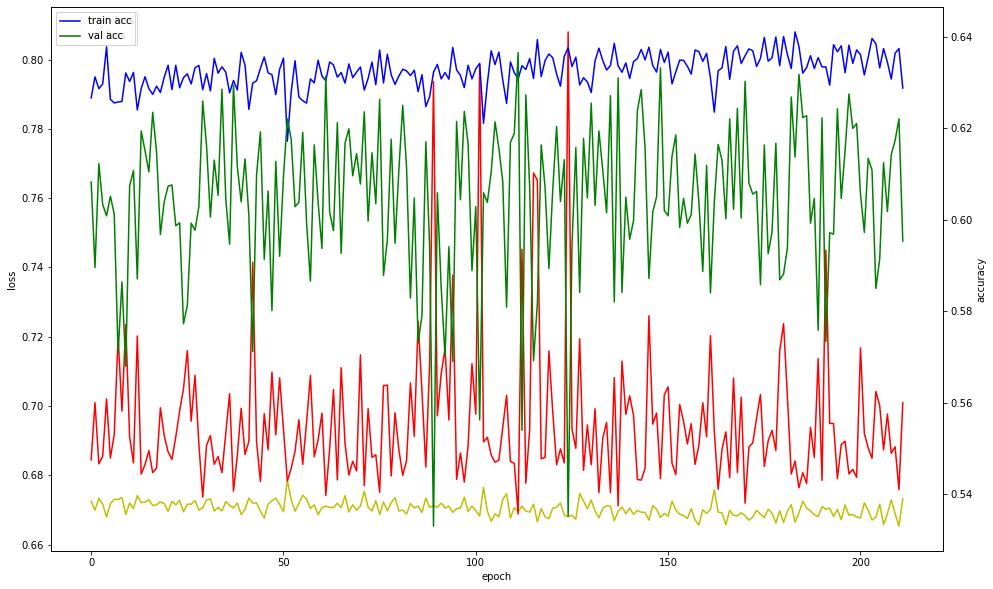

In [ ]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history_model.history['loss'], 'y', label='train loss')
loss_ax.plot(history_model.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history_model.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history_model.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(x_test, y_test, batch_size=128)

83/83 [==============================] - 0s 1ms/step - loss: 0.7009 - accuracy: 0.5953


In [ ]:
preds = model.predict(x_test, batch_size=128, verbose=1)

83/83 [==============================] - 0s 972us/step


In [ ]:
preds1=preds.argmax(axis=1)
print(preds1)

[1 0 1 ... 1 1 1]


In [ ]:
print(y_test.argmax(axis=1))


[1 0 0 ... 1 0 0]


## another

In [ ]:
model2 = Sequential([
    InputLayer(input_shape=x_train.shape[1]),
    Dense(108, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model2.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 108)               11772     
                                                                 
 dense_71 (Dense)            (None, 64)                6976      
                                                                 
 dense_72 (Dense)            (None, 32)                2080      
                                                                 
 dense_73 (Dense)            (None, 2)                 66        
                                                                 
Total params: 20,894
Trainable params: 20,894
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filepath = 'data_loss.h5'

history = model2.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=600,
    callbacks=[
        ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
    ]
)


Epoch 1/600
977/986 [============================>.] - ETA: 0s - loss: 0.7248 - acc: 0.5257   

In [ ]:
val_loss, val_acc = model2.evaluate(x_test, y_test, batch_size=128)

83/83 [==============================] - 0s 1ms/step - loss: 0.6762 - acc: 0.6280


## CNN model

In [ ]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
print(x_traincnn.shape, x_testcnn.shape)

(31551, 108, 1) (10517, 108, 1)


In [63]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same', input_shape=(108,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

C:\Users\mjw27\Anaconda3\envs\voices\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
callback = [ModelCheckpoint('model_cnn_256.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')]

cnnhistory=model.fit(x_traincnn, y_train, batch_size=256, epochs=800, validation_data=(x_testcnn, y_test), callbacks=callback)

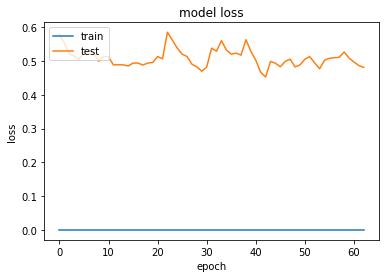

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## test


In [12]:
from keras.models import load_model
gender = ['man', 'woman']

loaded_model = load_model('model_cnn_mfcc20_256.h5')
data, sr = librosa.load('output.wav', duration=2.5, offset=0)
mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=20), axis=0)
mfcc = pd.DataFrame(data=mfccs)
mfcc = mfcc.stack().to_frame().T
print(mfcc.shape)

twodim = np.expand_dims(mfcc, axis=2)
print(twodim.shape)

(1, 108)
(1, 108, 1)


In [13]:
result = loaded_model.predict(twodim, batch_size=256, verbose=1)
label = int(result.argmax(axis=1))
print(f"predict gender: {gender[label]}")

1/1 [==============================] - 0s 92ms/step
predict gender: woman


22050 88064


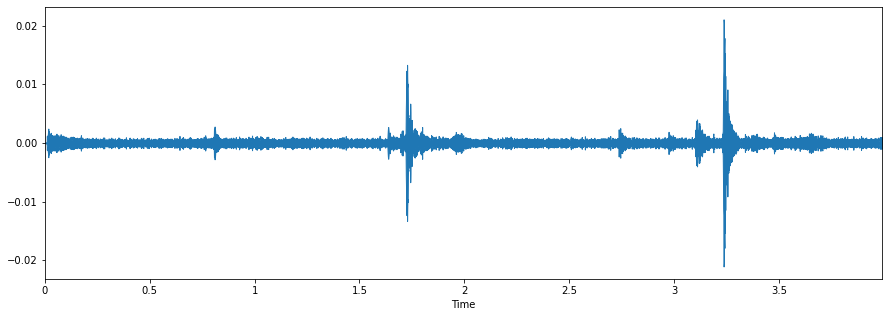

In [7]:
x, sr = librosa.load('output.wav')
print(sr, len(x))
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sr)